## **Goal**

Using data about wells in Tanzania. The goal is to see if you can create a model to predict which water wells will be faulty, in order to go and fix them. The score will be based on 'accuracy'. 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

pd.set_option('display.max_columns', 500)
y_train = pd.read_csv('/Users/lambda_school_loaner_95/Downloads/train_labels.csv')
X_train = pd.read_csv('/Users/lambda_school_loaner_95/Downloads/train_features.csv')
X_test = pd.read_csv('/Users/lambda_school_loaner_95/Downloads/test_features.csv')

**Quick Baseline**

In [2]:
X_train.shape

(59400, 40)

In [4]:
y_train['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

Basic baseline to beat is 54% coming from the majority class in the target data.

# Beat the baseline

In [5]:
y_train_target = y_train['status_group']

In [50]:
y_train['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X_train_numbers = X_train[X_train.describe().columns]

basic_model = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42)
cross_val_score(basic_model, X_train_numbers, y_train_target, scoring='accuracy', cv=5).mean()

/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_clas

0.551801290559174

Okay... that did not do too well. But a slight improvement nonetheless. Moving on

# Clean data, feature engineer, test different models

In [7]:
## function that cleans the data, adds some features, ordinally encodes everything that is left

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def wrangle_wells(X):
    X = X.copy()
    
    # feature: get days passed since date recorded
    X['last_day'] = '2014-01-01'
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['last_day'] = pd.to_datetime(X['last_day'], infer_datetime_format=True)
    X['offset_days'] = X['last_day'] - X['date_recorded']
    X['offset_days'] = X['offset_days'].dt.days
    
    # month date was recorded
    X['month_recorded'] = X['date_recorded'].dt.month
    
    # years in service
    X['construction_year'].fillna(X.groupby(['region', 'district_code'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X.groupby(['region'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X['construction_year'].median(), inplace=True)
    
    X['years_service'] = X.date_recorded.dt.year - X.construction_year
    
    # lower levels for funder categoricals
    X.loc[X['funder'].isin((X['funder'].value_counts()[X['funder'].value_counts() < 850]).index), 'funder'] = 'other'
    
    # lower levels for installer
    X.loc[X['installer'].isin((X['installer'].value_counts()[X['installer'].value_counts() < 620]).index), 'installer'] = 'other'
    
    # Try and make colum data a little more uniform
    X.waterpoint_type = X.waterpoint_type.str.lower()
    X.funder = X.funder.str.lower()
    X.basin = X.basin.str.lower()
    X.region = X.region.str.lower()
    X.source = X.source.str.lower()
    X.lga = X.lga.str.lower()
    X.management = X.management.str.lower()
    X.quantity = X.quantity.str.lower()
    X.water_quality = X.water_quality.str.lower()
    X.payment_type = X.payment_type.str.lower()
    X.extraction_type = X.extraction_type.str.lower()
    
    # Lower cardinality of extraction type by adding to 'other' category
    X['extraction_type'] = X['extraction_type'].replace({'other - mkulima/shinyanga': 'other'})
    
    
    X = X.drop(columns=['recorded_by', 'quantity_group', 'date_recorded', 'wpt_name', 'num_private', 'subvillage',
                       'region_code', 'management_group', 'extraction_type_group', 'extraction_type_class',
                       'scheme_name', 'payment', 'water_quality', 'source_type', 'source_class', 'waterpoint_type_group',
                       'ward', 'public_meeting', 'last_day', 'construction_year'])
    
    xyscaler = StandardScaler() 
    xyscaler.fit_transform(X[['latitude','longitude']])

    X["rot45X"] = .707* X['longitude'] + .707* X['latitude'] 
    X["rot45Y"] = .707* X['longitude'] - .707* X['latitude']

    X["rot30X"] = (1.732/2)* X['latitude'] + (1./2)* X['longitude'] 
    X["rot30Y"] = (1.732/2)* X['longitude'] - (1./2)* X['latitude']

    X["rot60X"] = (1./2)* X['latitude'] + (1.732/2)* X['longitude'] 
    X["rot60Y"] = (1./2)* X['longitude'] - (1.732/2)* X['latitude']

    X["radial_r"] = np.sqrt( np.power(X['longitude'],2) + np.power(X['latitude'],2) )
    
    
    return X

In [8]:
## wrangle the test and train data

X_test1 = wrangle_wells(X_train)
X_test2 = wrangle_wells(X_test)

In [9]:
## pre process train data to Ordinally Encode and then impute average values for all NaN's

from sklearn.pipeline import make_pipeline

features = ['id', 'amount_tsh', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude',
       'basin', 'region', 'district_code', 'lga',
       'population',
       'scheme_management', 'permit',
       'extraction_type',
       'management', 'payment_type',
       'quality_group', 'quantity',
       'source', 'waterpoint_type',
       'offset_days', 'month_recorded', 'years_service',
       'rot45X', 'rot45Y', 'rot30X', 'rot30Y', 'rot60X', 'rot60Y', 'radial_r'
   ]

preprocessor = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())
X_test1 = preprocessor.fit_transform(X_test1)
X_test1 = pd.DataFrame(X_test1, columns=features)

In [10]:
# transform test data in the same way as the train data

X_teste2 = preprocessor.transform(X_test2)
X_teste2 = pd.DataFrame(X_teste2, columns=features)

In [11]:
## test different models to see which will work best

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

models = [LogisticRegression(solver='lbfgs', max_iter=1000),
          DecisionTreeClassifier(max_depth=3),
          DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(max_depth=3, n_estimators=50, n_jobs=-1, random_state=42),
          RandomForestClassifier(max_depth=None, n_estimators=50, n_jobs=-1, random_state=42),
          XGBClassifier(max_depth=3, n_estimators=50, n_jobs=-1, random_state=42)]

for model in models:
  print(model, '\n')
  score = cross_val_score(model, X_test1, y_train_target, scoring='accuracy', cv=5).mean()
  print('Cross_Validation Accuracy:', score, '\n', '\n')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False) 



/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/lambda_school_loaner_95/anaconda3/lib/pyth

Cross_Validation Accuracy: 0.6063973696515584 
 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Cross_Validation Accuracy: 0.6934514989614184 
 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Cross_Validation Accuracy: 0.7466330313376597 
 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
      

At quick glance, it is nice to see that the data cleaning did help, even with the logistic regression model, the scores improved.  It is nice to see some significant jumps in scores with other models as well.  Even something as simple as a single decision tree can get the score up in the 70's.  Maybe due to some leakage somewhere.. maybe there are some highly predictive features in the model.  Not sure yet.  Either way, the Random Forest Classifier did the best, so that is what I will stick with

# Model that Overfits

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

searchRF = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=10,
    return_train_score=True,
    random_state=42
)

searchRF.fit(X_test1, y_train_target)


In [70]:
resultsRF = pd.DataFrame(searchRF.cv_results_)
resultsRF.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
11,720.509379,5.798710,13.033700,0.503160,2000,2,4,auto,90,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.819880,0.811716,0.815152,0.817088,0.816720,0.816111,0.002675,1,0.951893,0.951598,0.952041,0.950526,0.951707,0.951553,0.000536
33,729.220552,16.964503,12.409712,1.579188,2000,2,4,auto,70,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.819880,0.811716,0.815152,0.817088,0.816720,0.816111,0.002675,1,0.951893,0.951598,0.952041,0.950526,0.951707,0.951553,0.000536
9,349.453606,1.907269,5.406091,0.230610,1000,5,4,sqrt,90,False,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.820638,0.811295,0.815067,0.816414,0.815794,0.815842,0.002987,3,0.951851,0.951619,0.951999,0.950442,0.951917,0.951566,0.000576
42,5063.786933,2447.550383,3.359759,0.492994,600,5,1,auto,60,True,"{'n_estimators': 600, 'min_samples_split': 5, ...",0.820554,0.813736,0.816835,0.813636,0.813605,0.815673,0.002733,4,0.981481,0.981902,0.981860,0.981566,0.981524,0.981667,0.000178
5,408.932301,2.189365,10.959561,1.006485,1600,5,2,sqrt,50,True,"{'n_estimators': 1600, 'min_samples_split': 5,...",0.821227,0.811800,0.815909,0.815152,0.814278,0.815673,0.003102,4,0.954671,0.954797,0.955471,0.954482,0.954926,0.954870,0.000335
18,493.976887,6.552700,7.843262,0.624889,1400,5,4,sqrt,30,False,"{'n_estimators': 1400, 'min_samples_split': 5,...",0.820217,0.810959,0.816077,0.816498,0.814531,0.815657,0.003001,6,0.950946,0.950525,0.951157,0.950021,0.950928,0.950715,0.000403
19,592.136366,70.995140,16.395862,2.649887,2000,5,1,sqrt,70,True,"{'n_estimators': 2000, 'min_samples_split': 5,...",0.820217,0.813147,0.816498,0.814731,0.813605,0.815640,0.002564,7,0.982070,0.982239,0.982029,0.981713,0.981924,0.981995,0.000174
48,511.176914,5.466096,13.474008,1.147614,2000,5,1,sqrt,50,True,"{'n_estimators': 2000, 'min_samples_split': 5,...",0.820217,0.813147,0.816498,0.814731,0.813605,0.815640,0.002564,7,0.982028,0.982239,0.982050,0.981734,0.981924,0.981995,0.000165
7,452.435272,7.082760,10.639169,0.572026,1800,5,2,auto,30,True,"{'n_estimators': 1800, 'min_samples_split': 5,...",0.821059,0.811885,0.815741,0.814815,0.814531,0.815606,0.003013,9,0.953976,0.953598,0.954524,0.953556,0.954105,0.953952,0.000356
36,145.618699,0.554082,2.863658,0.061974,600,10,1,sqrt,None,True,"{'n_estimators': 600, 'min_samples_split': 10,...",0.819712,0.813484,0.816667,0.814646,0.813184,0.815539,0.002419,10,0.935184,0.936299,0.935438,0.934933,0.935461,0.935463,0.000460


# Final Model Plus Analysis

In [17]:
best_model = RandomForestClassifier(max_depth=None, n_estimators=320, n_jobs=-1, random_state=42)
score = cross_val_score(best_model, X_test1, y_train_target, scoring='accuracy', cv=5)

In [23]:
score.mean()

0.8098149237465961

In [ ]:
best_model.fit(X_test1, y_train_target)

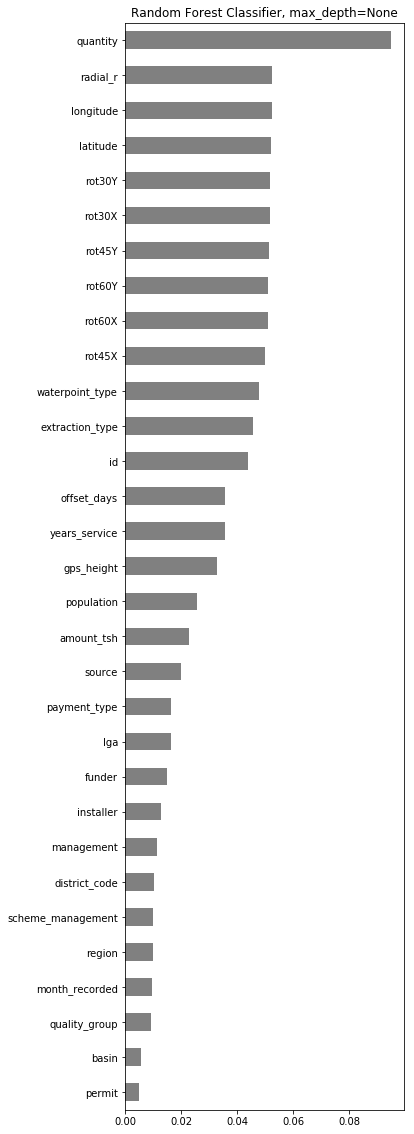

In [31]:
import matplotlib.pyplot as plt

figsize = (5,20)

name = 'Random Forest Classifier'
importances = pd.Series(best_model.feature_importances_, X_test1.columns)
title = f'{name}, max_depth={best_model.max_depth}'

plt.figure(figsize=figsize)
importances.sort_values().plot.barh(color='grey', title=title)



In [34]:
conda install -c conda-forge eli5

Solving environment: \ 
  - anaconda::ca-certificates-2019.1.23-0
  - defaults::ca-certificates-2019.1.23done

## Package Plan ##

  environment location: /Users/lambda_school_loaner_95/anaconda3

  added / updated specs:
    - eli5


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cairo-1.14.12              |    h9d4d9ac_1005         1.3 MB  conda-forge
    certifi-2019.3.9           |           py37_0         149 KB  conda-forge
    conda-4.6.14               |           py37_0         2.1 MB  conda-forge
    eli5-0.8.1                 |             py_0          65 KB  conda-forge
    fontconfig-2.13.1          |    h1027ab8_1000         269 KB  conda-forge
    fribidi-1.0.5              |    h1de35cc_1000          62 KB  conda-forge
    graphite2-1.3.13           |    h2098e52_1000          84 KB  conda-forge
    graphviz-2.40.1            |       hefbbd9a_2         6.7 MB
    harfbu

In [35]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best_model, scoring='accuracy', cv='prefit',
                                n_iter=2, random_state=42)

permuter.fit(X_test1.values, y_train_target)

PermutationImportance(cv='prefit',
           estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=320, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
           n_iter=2, random_state=42, refit=True, scoring='accuracy')

In [36]:
feature_names = X_test1.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1608 ± 0.0011,quantity
0.0508 ± 0.0000,extraction_type
0.0480 ± 0.0005,waterpoint_type
0.0360 ± 0.0002,years_service
0.0352 ± 0.0009,amount_tsh
0.0132 ± 0.0007,population
0.0121 ± 0.0000,id
0.0101 ± 0.0008,payment_type
0.0091 ± 0.0003,funder
0.0074 ± 0.0003,offset_days


# Realizations
I hope to be doing further exploration on this dataset.  Biggest take aways so far
- Having a clear process is very helpful to make quick incrememntal gains
- Going for an over fitted model early on was helpful mindset to have
- Domain knowledge is best for efficient feature engineering
- Goal should be to plateau on score as fast as possible, then analyze the data to form real conclusions (the extra .0001 percent is not worth the time)
- don't lose track of the problem at hand when trying to make 'the best' model
- Stacking models together can be very valuable
- simple is good

# Submission blocks

In [64]:
# estimator = RandomForestClassifier(max_depth=None, n_estimators=320, n_jobs=-1, random_state=42)
# estimator.fit(X_test1, y_train_target)

# y_pred = estimator.predict(X_teste2)

# sample_submission = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle/14688/453539/sample_submission.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1558636843&Signature=F8VvtSyMe9kPksSP5FK2hKnYJw6XMBytCjBIg%2Fkec7Ddcf%2Bue4Ge%2FGxHKWkr%2FZBgR6i%2FZt36WV4cSDnD2XCSJJ4%2F%2Bk23YsN9fi7F29W4E6worpqUlfCTk%2FNNB3y96EIkTZ7YNzh7inKZ93tB%2BxcAkyKnOseWQ3y8iGRDPRU7%2BXPeYretRM%2FBLqSbYU4gRUGxhSCwww3cRbsWi%2FRMcWq5YyypMOCuCBI7hJ7HIUc47u2WAjsleNEKGvJ69I82aral8%2FzercReL2rGCKfTTPsJ0WRH%2FTdJjHQ2O6EJ4l9AfUe7Dqjqjj8XCYFKaFfec5B8htoxTgkBcqG4GKhWEU%2B65w%3D%3D')
# baseline_submission13 = sample_submission.copy()
# baseline_submission13['status_group'] = y_pred
# baseline_submission13.to_csv('baseline_submission13.csv', index=False)

In [61]:
#best_estimator = searchRF.best_estimator_
# model.fit(X_test1, y_train_target)

# y_pred = model.predict(X_teste2)



In [63]:
# sample_submission = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle/14688/453539/sample_submission.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1558905720&Signature=INefpYzy5J4FBdIujvu9QVAhAMmJ0ahuW3bootCsHUaUuuKoJzgyA5rAsknVCOFY8hSWDQrZ%2FgBkCgnLniVB6rHKeMNEl4HAYOe0RN54uY0bvqmYKWr3aARaQk7YCKka28S5WtjI7HkjM%2BbXZkP4dYlt8NRjAoVSdiaWsysUwxXeRRGIBuhrt%2FuBSAPk3CegyHXikAsEHx0VKhdRNIv%2BrHyXOu2Y1ldloSvxcrQdmI%2BirQrxXJLT7XD6tI5leaYbXit6tQ2X5syfBek31o31B7AkMqz%2B9zIlZ5SBDMhOXbdaxEZMGaE7NRFEioLq%2Fp3GtolWe97qrOnvoHybd2PBsg%3D%3D')
# baseline_submission16 = sample_submission.copy()
# baseline_submission16['status_group'] = y_pred
# baseline_submission16.to_csv('baseline_submission16.csv', index=False)

In [64]:
#Filenames of your submissions you want to ensemble
# sample_submission = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle/14688/453539/sample_submission.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1558636843&Signature=F8VvtSyMe9kPksSP5FK2hKnYJw6XMBytCjBIg%2Fkec7Ddcf%2Bue4Ge%2FGxHKWkr%2FZBgR6i%2FZt36WV4cSDnD2XCSJJ4%2F%2Bk23YsN9fi7F29W4E6worpqUlfCTk%2FNNB3y96EIkTZ7YNzh7inKZ93tB%2BxcAkyKnOseWQ3y8iGRDPRU7%2BXPeYretRM%2FBLqSbYU4gRUGxhSCwww3cRbsWi%2FRMcWq5YyypMOCuCBI7hJ7HIUc47u2WAjsleNEKGvJ69I82aral8%2FzercReL2rGCKfTTPsJ0WRH%2FTdJjHQ2O6EJ4l9AfUe7Dqjqjj8XCYFKaFfec5B8htoxTgkBcqG4GKhWEU%2B65w%3D%3D')
# files = ['baseline_submission15.csv', 'baseline_submission14.csv', 'baseline_submission13.csv',
#         'baseline_submission5.csv', 'baseline_submission4.csv', 'baseline_submission16.csv']

# submissions = (pd.read_csv(file)[['status_group']] for file in files)
# ensemble = pd.concat(submissions, axis='columns')
# majority_vote = ensemble.mode(axis='columns')[0]


# sample_submission = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle/14688/453539/sample_submission.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1558905720&Signature=INefpYzy5J4FBdIujvu9QVAhAMmJ0ahuW3bootCsHUaUuuKoJzgyA5rAsknVCOFY8hSWDQrZ%2FgBkCgnLniVB6rHKeMNEl4HAYOe0RN54uY0bvqmYKWr3aARaQk7YCKka28S5WtjI7HkjM%2BbXZkP4dYlt8NRjAoVSdiaWsysUwxXeRRGIBuhrt%2FuBSAPk3CegyHXikAsEHx0VKhdRNIv%2BrHyXOu2Y1ldloSvxcrQdmI%2BirQrxXJLT7XD6tI5leaYbXit6tQ2X5syfBek31o31B7AkMqz%2B9zIlZ5SBDMhOXbdaxEZMGaE7NRFEioLq%2Fp3GtolWe97qrOnvoHybd2PBsg%3D%3D')
# submission = sample_submission.copy()
# submission['status_group'] = majority_vote
# submission.to_csv('ensemble-submission2.csv', index=False)